### Задание

#### *Прочитайте базу нефть-brent 2010-2019(в3)*

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
oil=pd.read_csv("нефть-brent-2010-2019.csv",',', index_col=['date'], parse_dates=['date']) 
oil.head(15)

,val
date,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59
2019-08-26,58.26
2019-08-25,57.81
2019-08-23,58.94
2019-08-22,60.05


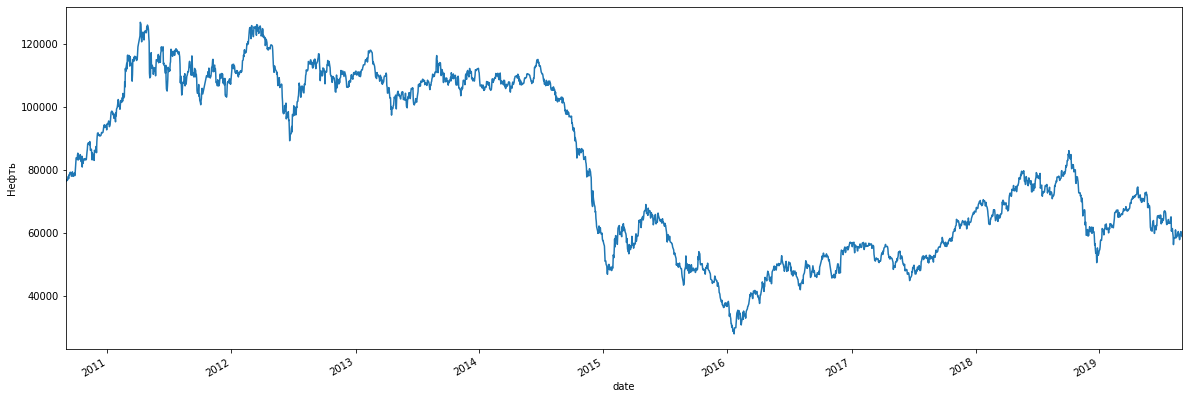

In [3]:
oil.val=oil.val*1000
plt.figure(figsize(20,7))
oil.val.plot()
plt.ylabel('Нефть')
pylab.show()

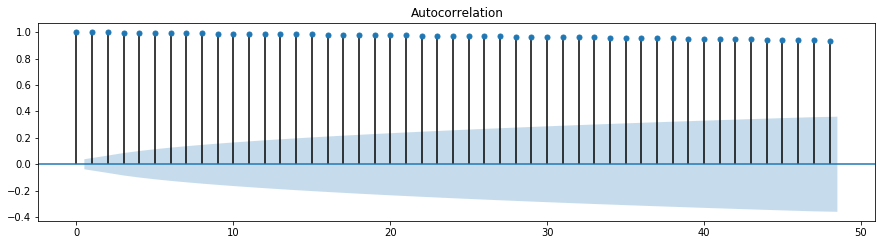

In [4]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(oil.val[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Стабилизация дисперсии (Преобразование Бокса-Кокса)

Оптимальный параметр преобразования Кокса- Бокса: 0.673894
 Критерий Дики-Фуллера: p=0.640408


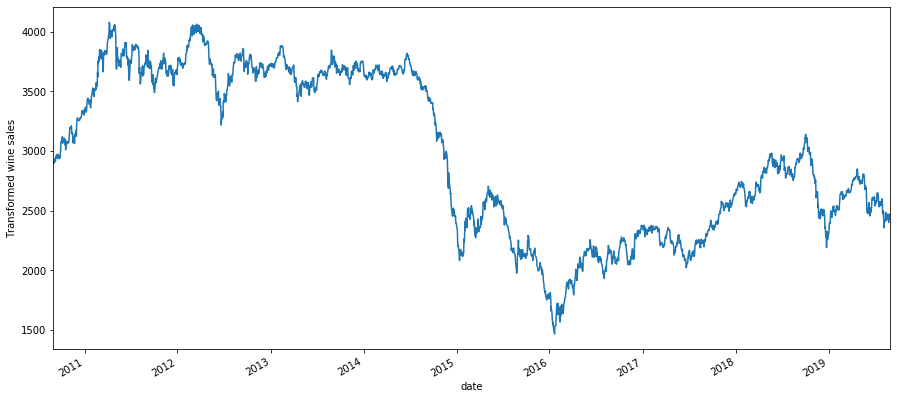

In [5]:
oil['val_box'], lmbda = stats.boxcox(oil.val)
plt.figure(figsize(15,7))
oil.val_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(oil.val_box)[1])

Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд.

Сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

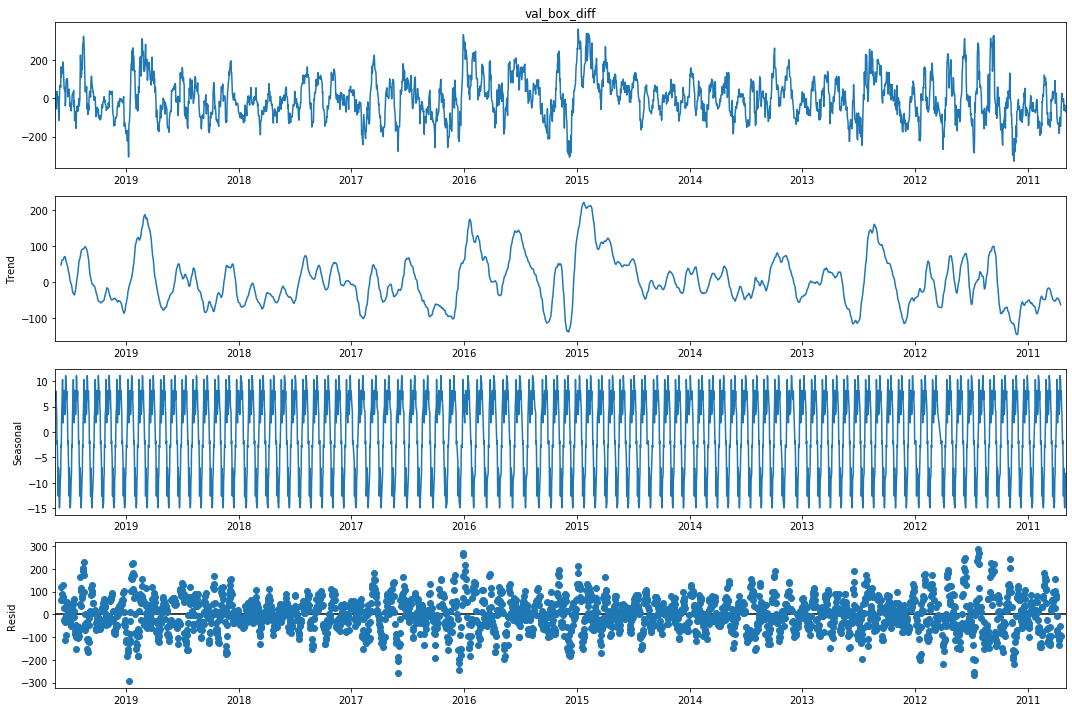

In [21]:
oil['val_box_diff'] = oil.val_box - oil.val_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(oil.val_box_diff[12:], freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(oil.val_box_diff[12:])[1])

Гипотеза нестационарности отвергается. Тренда нет

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

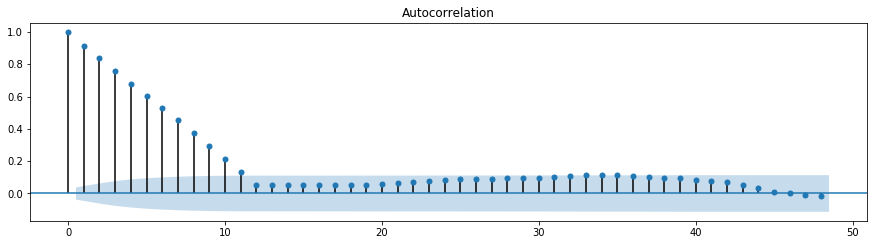

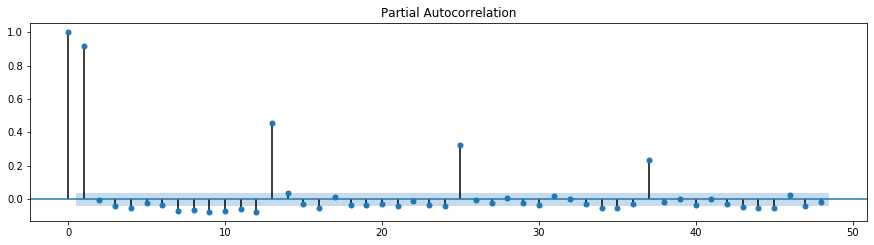

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(oil.val_box_diff[13:].values.squeeze(), lags=4*12, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(oil.val_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближений: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(oil.val_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 8min 39s


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
13  (1, 0, 0, 1)  25854.510685
5   (0, 1, 0, 1)  25854.662024
15  (1, 0, 1, 1)  25855.011412
29  (2, 1, 0, 1)  25855.058854
45  (3, 2, 0, 1)  25855.106760


**Лучшая модель:**

In [24]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              val_box   No. Observations:                 2667
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood              -12924.255
Date:                              Wed, 18 Mar 2020   AIC                          25854.511
Time:                                      13:19:11   BIC                          25872.162
Sample:                                           0   HQIC                         25860.900
                                             - 2667                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0649      0.016     -3.977      0.000      -0.097      -0.033
ma.S.L12      -0.99

**Ее остатки:**

 Критерий —Стьюдента: p=0.582825
 Критерий Дики-Фуллера: p=0.000000


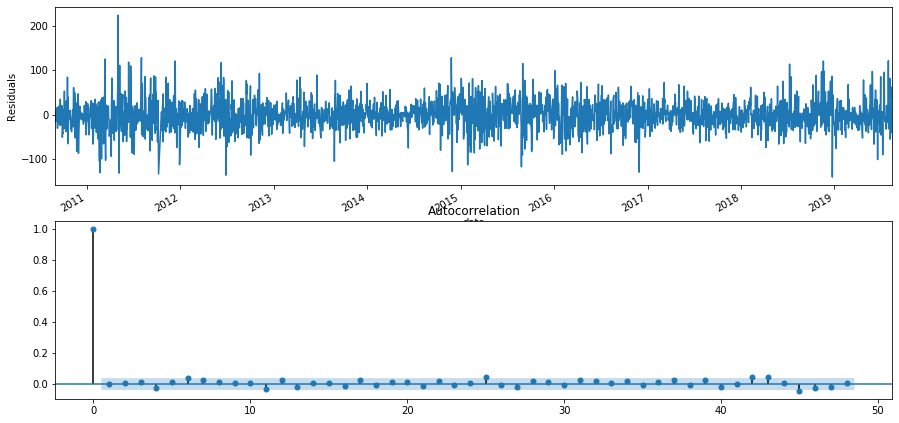

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий —Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием —Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Тьюнга-Кокса и коррелограммой). ѕосмотрим, насколько хорошо модель описывает данные:

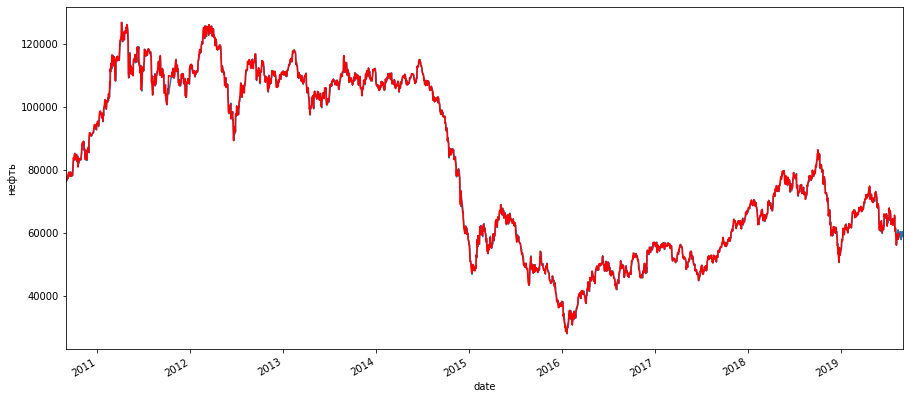

In [26]:
oil['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
oil.val.plot()
oil.model[13:].plot(color='r')
plt.ylabel('нефть')
pylab.show()

*Взят график с 2009-09-01*

<Figure size 1368x504 with 0 Axes>

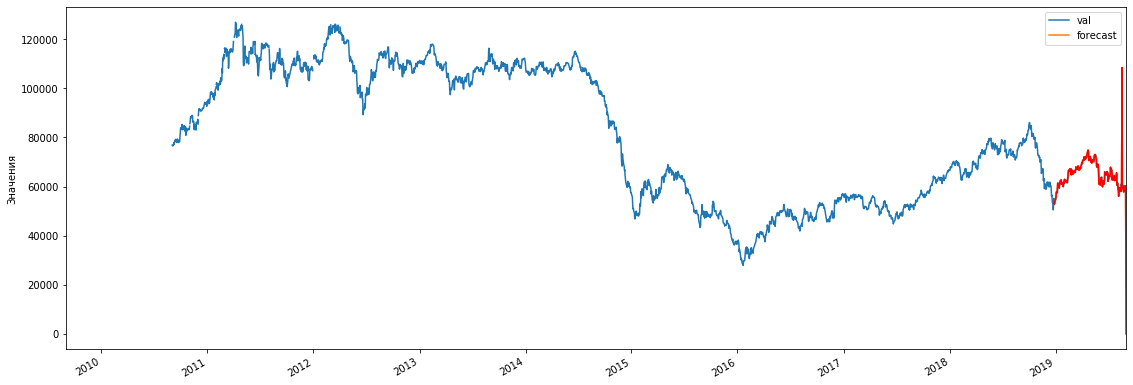

In [31]:

from dateutil.relativedelta import relativedelta
df2 = oil[['val']]
date_list = [datetime.datetime.strptime("2009-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=0, end=211), lmbda)

plt.figure(figsize(19,7))
df2.plot()
df2.forecast.plot(color='r')
plt.ylabel('Значения')
pylab.show()